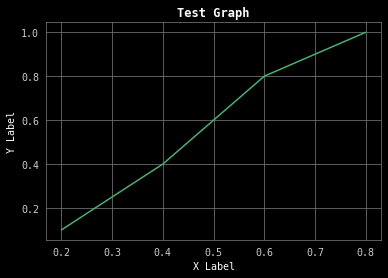

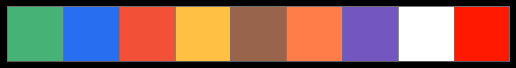

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("darkgrid", {"axes.facecolor": "black",    # grid styles
                           'axes.edgecolor': '#727272',
                           'grid.color': '#727272',
                           'figure.facecolor': 'black',
                           'text.color': '#ffffff',        # TEXT STYLES
                           'font.family': ['monospace'],
                           'font.sans-serif': ['Helvetica',
                                               'sans-serif'],
                           'patch.edgecolor': '#000000',
                           'axes.labelcolor': '#ffffff',
                           'xtick.color': '#cccccc',
                           'ytick.color': '#cccccc',
                          })

uber = sns.color_palette(["#47B275","#276EF1", "#F25138", "#FFC043", 
                          "#99644C", "#FF7D49", "#7356BF","#ffffff", "#FF1901"])
sns.set_palette(uber)
plt.title('Test Graph', weight='bold')
plt.plot([.2,.4,.6,.8],[.1,.4,.8,1])
plt.xlabel('X Label')
plt.ylabel('Y Label')
sns.palplot(uber)

## Load Couriers Data & Build Columns

In [137]:
couriers.columns

Index(['week', 'partner_uuid', 'total_hours_online', 'boost_earnings',
       'total_earnings', 'base_earnings', 'base_earnings_per_hour',
       'total_earnings_per_hour', 'boost_per_hour', 'boost_rate', 'boost',
       'est_orders', 'base_earnings_per_est_order',
       'boost_earnings_per_est_order', 'eff_score', 'boost_eff_score',
       'total_hours_buckets', 'rolling_total_hours', 'rolling_base_earnings',
       'week_rn', 'rolling_base_earnings_per_hour', 'boost_rate_rnd',
       'base_earnings_per_hour_rnd'],
      dtype='object')

In [2]:
couriers = pd.read_excel('/Users/thomasbriggs/Downloads/DB2 - COURIERS.xlsx', header=1)

In [3]:
couriers['base_earnings'] = couriers['total_earnings'] - couriers['boost_earnings'].fillna(0)
couriers['base_earnings_per_hour'] = (couriers['total_earnings'] - couriers['boost_earnings'].fillna(0)) / couriers['total_hours_online']
couriers['total_earnings_per_hour'] = couriers['total_earnings'] / couriers['total_hours_online']
couriers['boost_per_hour'] = couriers['boost_earnings'] / couriers['total_hours_online']
couriers['boost_rate'] = (couriers['boost_earnings'] / couriers['base_earnings']) #*couriers['total_hours_online']

couriers['boost'] = np.where(couriers['boost_earnings'].isna(), 0, 1)

couriers = couriers.loc[couriers['partner_uuid'].isna()==False]

# Going by the rate of orders needed per courier hour in the orders sheet
couriers['est_orders'] = np.where(
    (couriers['total_earnings']==0) & (couriers['total_hours_online']<.75)
    , 0
    , np.where(
        couriers['total_hours_online']<1.5
        ,1
        , couriers['total_hours_online'] * .75
    )
)

couriers['base_earnings_per_est_order'] = couriers['base_earnings'] / couriers['est_orders']
couriers['boost_earnings_per_est_order'] = couriers['boost_earnings'] / couriers['est_orders']

# a metric that incentivizes high hours online and high amount of orders
couriers['eff_score'] = couriers['base_earnings_per_est_order'] / couriers['total_hours_online']
couriers['boost_eff_score'] = couriers['boost_earnings_per_est_order'] / couriers['total_hours_online']

# Bucket Hours together
couriers['total_hours_buckets'] = np.where(
    couriers.total_hours_online<1
    ,'<1'
    ,np.where(
        (couriers.total_hours_online>=1)&(couriers.total_hours_online<5)
        ,'1–5'
        ,np.where(
            (couriers.total_hours_online>=5)&(couriers.total_hours_online<10)
            ,'5-10'
            ,np.where(
                (couriers.total_hours_online>=10)&(couriers.total_hours_online<15)
                ,'10-15'
                ,np.where(
                    (couriers.total_hours_online>=15)
                    ,'>15'
                    ,None
                )
            )
        )
    ))


# Window Functions
couriers = (couriers.assign(
    rolling_total_hours=couriers.sort_values(['week']).groupby('partner_uuid').total_hours_online.cumsum()
))
couriers = (couriers.assign(
    rolling_base_earnings=couriers.sort_values(['week']).groupby('partner_uuid').base_earnings.cumsum()
))

couriers['week_rn'] = couriers.sort_values(['week']).groupby(['partner_uuid']).cumcount()+1

couriers['rolling_base_earnings_per_hour'] = couriers['rolling_base_earnings'] / couriers['rolling_total_hours']

## Rounded Variables
def custom_round(x, base):
    return base * round(float(x)/base)

rnd = []
for i in couriers['boost_rate']:
    try:
        rnd.append(custom_round(i,.25))
    except:
        rnd.append(None)
        
couriers['boost_rate_rnd'] = rnd
couriers['boost_rate_rnd'] = couriers['boost_rate_rnd'].astype('category')

rnd = []
for i in couriers['base_earnings_per_hour']:
    try:
        rnd.append(custom_round(i,2.5))
    except:
        rnd.append(None)
        
couriers['base_earnings_per_hour_rnd'] = rnd
couriers['base_earnings_per_hour_rnd'] = couriers['base_earnings_per_hour_rnd'].astype('category')



couriers.head()

,week,partner_uuid,total_hours_online,boost_earnings,total_earnings,base_earnings,base_earnings_per_hour,total_earnings_per_hour,boost_per_hour,boost_rate,...,boost_earnings_per_est_order,eff_score,boost_eff_score,total_hours_buckets,rolling_total_hours,rolling_base_earnings,week_rn,rolling_base_earnings_per_hour,boost_rate_rnd,base_earnings_per_hour_rnd
0,2019-10-28,680d9e50-20c6-4825-a003-a09a9aad3e5f,4.000000,NaN,78.24,78.24,19.560000,19.560000,NaN,NaN,...,NaN,6.520000,NaN,1–5,4.000000,78.24,1,19.560000,NaN,20.0
1,2019-10-28,9f030ecb-0227-4209-98cb-7ca5b17928b8,1.666667,22.05,50.20,28.15,16.890000,30.120000,13.230,0.783304,...,17.640,13.512000,10.584000,1–5,1.666667,28.15,1,16.890000,0.75,17.5
2,2019-10-28,64a3fb35-747d-484c-8b2a-d171b9dd949d,4.666667,55.09,146.88,91.79,19.669286,31.474286,11.805,0.600174,...,15.740,5.619796,3.372857,1–5,4.666667,91.79,1,19.669286,0.50,20.0
3,2019-10-28,cad33a13-d932-43d9-b2c4-afcd108ef3c8,1.666667,4.54,29.44,24.90,14.940000,17.664000,2.724,0.182329,...,3.632,11.952000,2.179200,1–5,1.666667,24.90,1,14.940000,0.25,15.0
4,2019-10-28,dd7be50b-1373-4a55-a687-f71c33ea053a,0.333333,NaN,22.67,22.67,68.010000,68.010000,NaN,NaN,...,NaN,68.010000,NaN,<1,0.333333,22.67,1,68.010000,NaN,67.5


In [4]:
len(couriers.loc[couriers.est_orders.round() ==1]) / len(couriers)

0.609536853069964

## Summary of Courier Data

In [5]:
summary = couriers.groupby('week').agg({
    'partner_uuid':'nunique',
    'total_hours_online':'sum',
    'boost_earnings':'sum',
    'base_earnings':'sum',
    'total_earnings':'sum'
}).reset_index().rename(columns={
    'partner_uuid':'num_couriers',
    'total_hours_online':'actual_courier_hours'
})

summary['est_actual_orders'] = summary['actual_courier_hours']*.75

summary['est_boost_per_order'] = summary['boost_earnings'] / summary['est_actual_orders']

summary['est_hours_per_order'] = summary['actual_courier_hours'] / summary['est_actual_orders']

summary['base_earnings_per_order'] = summary['base_earnings'] / summary['est_actual_orders']
summary['total_earnings_per_order'] = summary['total_earnings'] / summary['est_actual_orders']
summary['couriers_per_order'] = summary['num_couriers'] / summary['est_actual_orders']

summary

,week,num_couriers,actual_courier_hours,boost_earnings,base_earnings,total_earnings,est_actual_orders,est_boost_per_order,est_hours_per_order,base_earnings_per_order,total_earnings_per_order,couriers_per_order
0,2019-10-28,15083,42278.666667,380318.26,8.546280e+05,1.234946e+06,31709.00,11.994016,1.333333,26.952222,38.946238,0.475669
1,2019-11-04,27863,87747.000000,427351.94,2.337462e+06,2.764814e+06,65810.25,6.493699,1.333333,35.518212,42.011911,0.423384
2,2019-11-11,28157,89021.333333,477101.15,2.344224e+06,2.821325e+06,66766.00,7.145870,1.333333,35.111039,42.256909,0.421727
3,2019-11-18,33314,109605.666667,519318.36,3.148952e+06,3.668270e+06,82204.25,6.317415,1.333333,38.306432,44.623847,0.405259
4,2019-11-25,36814,114251.000000,771282.73,3.047743e+06,3.819025e+06,85688.25,9.001033,1.333333,35.567801,44.568834,0.429627
5,2019-12-02,14292,19551.000000,96904.42,5.815161e+05,6.784205e+05,14663.25,6.608659,1.333333,39.658061,46.266721,0.974682


# Distributions

Base earnings per hour and the Eff Score are incredibly lopsided. They both build off of each other but Eff score pushes the distribution farther down towards 0.

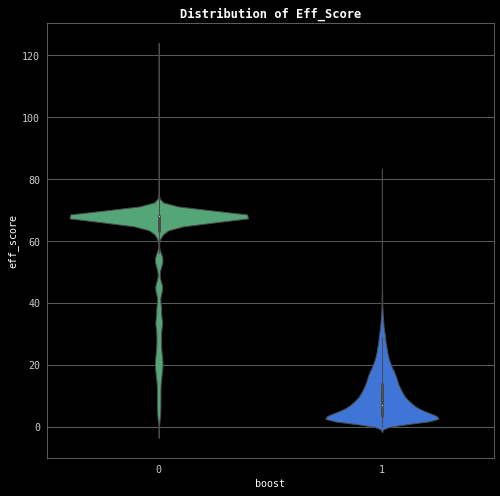

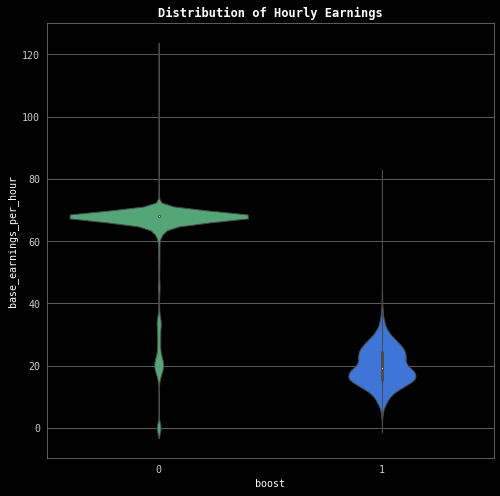

In [6]:
plt.figure(figsize=(8,8))
ax = sns.violinplot(
    data=couriers
    , x='boost'
    , y=couriers['eff_score']
#     , scale="count"                    
    , linewidth=1
)
ax = plt.title('Distribution of Eff_Score',weight='bold')

plt.figure(figsize=(8,8))
ax2 = sns.violinplot(
    data=couriers
    , x='boost'
    , y=couriers['base_earnings_per_hour']
#     , scale="count"                    
    , linewidth=1
)
ax2 = plt.title('Distribution of Hourly Earnings',weight='bold')

### Look at all the datapoints

Value Counts for Each with no limitations:
0    82921
1    72602
Name: boost, dtype: int64

Percent False Positive: 1.1421310707694003

Percent of Total Boost: 1.0
Percent of Total Non-Boost: 1.0


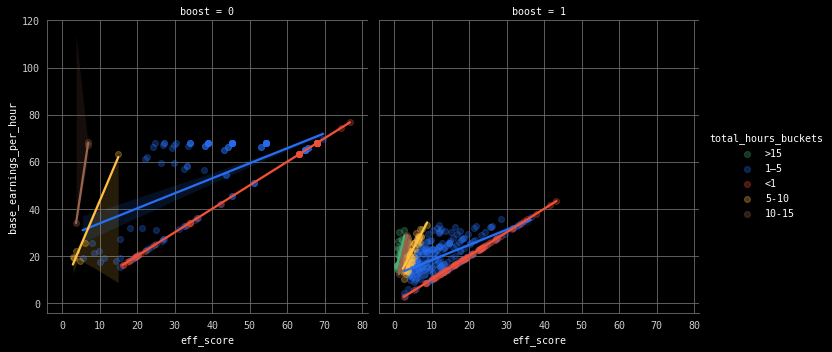

In [7]:
eff = couriers
print('Value Counts for Each with no limitations:')
print(eff['boost'].value_counts())

print('\nPercent False Positive: {}'.format(eff['boost'].value_counts()[0]/eff['boost'].value_counts()[1]))

print('\nPercent of Total Boost: {}'.format(eff['boost'].value_counts()[1]/len(couriers.loc[couriers.boost==1])))
print('Percent of Total Non-Boost: {}'.format(eff['boost'].value_counts()[0]/len(couriers.loc[couriers.boost==0])))

g = sns.lmplot(
    data=eff.sample(1000)
    , x="eff_score"
    , y="base_earnings_per_hour"
    , col='boost'
    , hue='total_hours_buckets'
    , col_wrap=2
    , scatter_kws={'alpha':0.3}
)
plt.show()

### Filtering out the predominantly non-boost areas

Value Counts for Each:
1    66588
0     6405
Name: boost, dtype: int64

Percent False Positive: 0.09618850243287079

Percent of Total Boost: 0.9171648163962425
Percent of Total Non-Boost: 0.07724219437778126


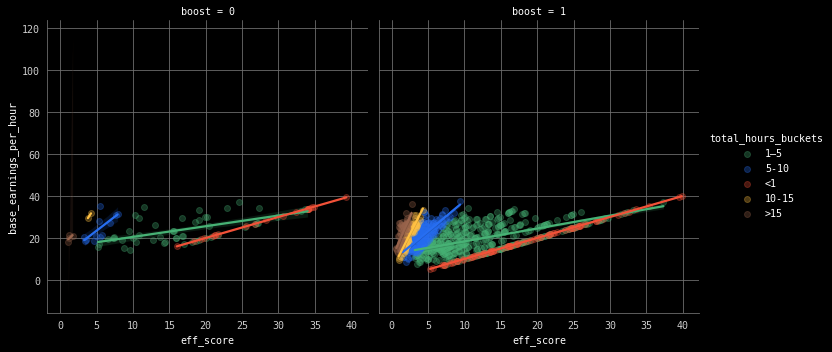

In [10]:
eff = couriers.loc[
    (couriers.base_earnings_per_hour < 40)
    &(couriers.eff_score<40)
    &((couriers.total_hours_online>1)|(couriers.week_rn>1))
]


print('Value Counts for Each:')
print(eff['boost'].value_counts())

print('\nPercent False Positive: {}'.format(eff['boost'].value_counts()[0]/eff['boost'].value_counts()[1]))

print('\nPercent of Total Boost: {}'.format(eff['boost'].value_counts()[1]/len(couriers.loc[couriers.boost==1])))
print('Percent of Total Non-Boost: {}'.format(eff['boost'].value_counts()[0]/len(couriers.loc[couriers.boost==0])))

g = sns.lmplot(
    data=eff.sample(1000)
    , x="eff_score"
    , y="base_earnings_per_hour"
    , col='boost'
    , hue='total_hours_buckets'
    , col_wrap=2
    , scatter_kws={'alpha':0.3}
)
plt.show()

___

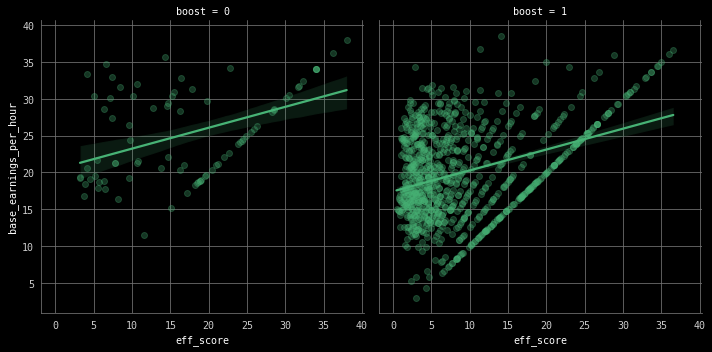

In [146]:
g = sns.lmplot(
    data=eff.sample(1000, random_state=1)
    , x="eff_score"
    , y="base_earnings_per_hour"
    , col='boost'
#     , hue='boost_rate_rnd'
    , col_wrap=2
    , scatter_kws={'alpha':0.3}
)
plt.show()

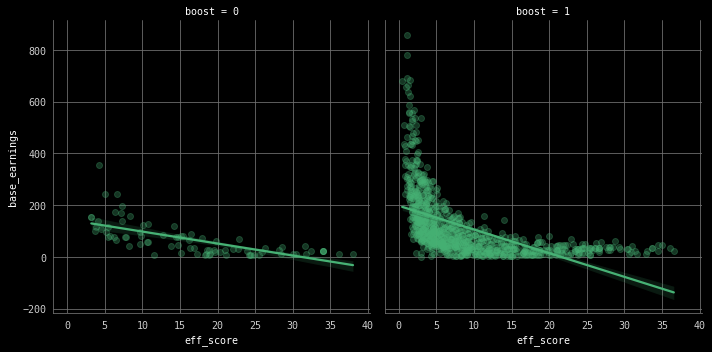

In [150]:
g = sns.lmplot(
    data=eff.sample(1000, random_state=1)
    , x="eff_score"
    , y="base_earnings"
    , col='boost'
#     , hue='total_hours_buckets'
    , col_wrap=2
    , scatter_kws={'alpha':0.3}
)
plt.show()

# Applying Boost Variable
Use condition logic to add the binary variable

In [11]:
couriers.week.unique()

array(['2019-10-28T00:00:00.000000000', '2019-11-04T00:00:00.000000000',
       '2019-11-11T00:00:00.000000000', '2019-11-18T00:00:00.000000000',
       '2019-11-25T00:00:00.000000000', '2019-12-02T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [53]:
# Not using the first week of the data set, so as to have at least some level of participation data
train = couriers.loc[couriers.week.isin(['2019-11-04T00:00:00.000000000','2019-11-11T00:00:00.000000000'
                                         ,'2019-11-18T00:00:00.000000000','2019-11-25T00:00:00.000000000'
                                         ,'2019-12-02T00:00:00.000000000'
                                        ])]

# Add the binary variable
train['boost_eligible_auto'] = np.where(
    (train.base_earnings_per_hour < 40)
    &(train.eff_score<40)
    # Also ineligible if it's their first week & they dont have an hour active
    &((train.total_hours_online>1)|(train.week_rn>1))
    ,1
    ,0
)

/Users/thomasbriggs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


____

### What the opposite of our filter looks like

Value Counts for Each:
0    68337
1      217
Name: boost, dtype: int64

Percent False Positive: 314.91705069124424

Percent of Total Boost: 0.0029888983774551663
Percent of Total Non-Boost: 0.8241217544409739


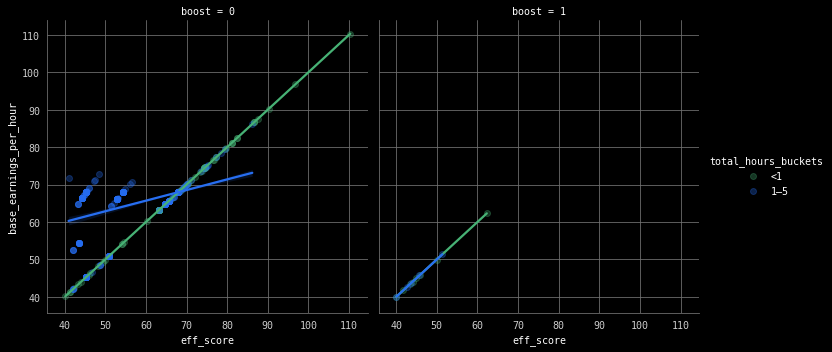

In [15]:
eff = couriers.loc[
    (couriers.base_earnings_per_hour > 40)
    &(couriers.eff_score>40)
#     &((couriers.total_hours_online>1)|(couriers.week_rn>1))
]


print('Value Counts for Each:')
print(eff['boost'].value_counts())

print('\nPercent False Positive: {}'.format(eff['boost'].value_counts()[0]/eff['boost'].value_counts()[1]))

print('\nPercent of Total Boost: {}'.format(eff['boost'].value_counts()[1]/len(couriers.loc[couriers.boost==1])))
print('Percent of Total Non-Boost: {}'.format(eff['boost'].value_counts()[0]/len(couriers.loc[couriers.boost==0])))

g = sns.lmplot(
    data=eff.sample(5000)
    , x="eff_score"
    , y="base_earnings_per_hour"
    , col='boost'
    , hue='total_hours_buckets'
    , col_wrap=2
    , scatter_kws={'alpha':0.3}
)
plt.show()

___

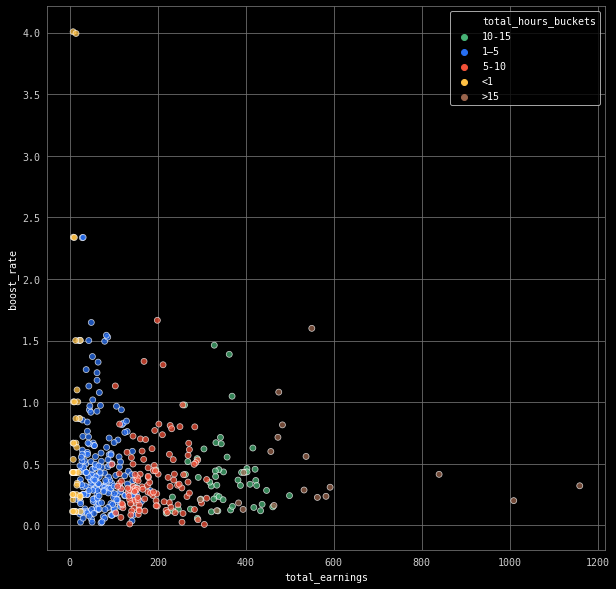

In [16]:
eff = couriers.loc[
    (couriers.base_earnings_per_hour < 40)
    &(couriers.eff_score<40)
    &((couriers.total_hours_online>1)|(couriers.week_rn>1))
]


plt.figure(figsize=(10,10))
# plt.plot([x1,x2],[y1,y2])
sns.scatterplot(
    data=eff.sample(500).sort_values(by='total_hours_buckets')
    ,x='total_earnings'
    ,y='boost_rate'
    ,hue='total_hours_buckets'
    ,alpha=.75
)

plt.show()

In [17]:
# Check the value counts
eff['est_orders'].loc[eff.boost_rate>3].value_counts()

1.00     204
1.50      23
1.25      22
1.75      13
2.25      11
2.50       9
2.00       8
2.75       6
3.00       4
3.50       4
4.50       3
3.25       3
3.75       3
4.25       2
7.00       2
5.25       1
9.75       1
4.75       1
6.75       1
6.25       1
5.75       1
11.00      1
4.00       1
Name: est_orders, dtype: int64

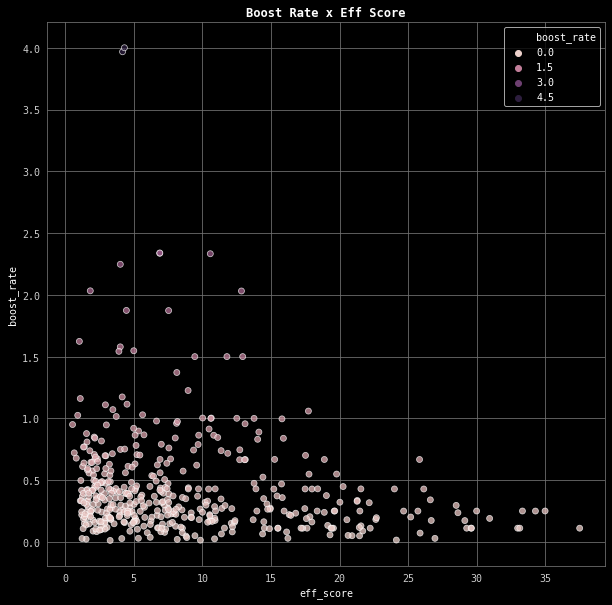

In [142]:
plt.figure(figsize=(10,10))
# plt.plot([x1,x2],[y1,y2])
sns.scatterplot(
    data=eff.sample(500).sort_values(by='total_hours_buckets')
    ,x='eff_score'
    ,y='boost_rate'
    ,hue='boost_rate'
#     ,style='week'
    ,alpha=.75
)
plt.title('Boost Rate x Eff Score', weight='bold')
plt.show()

In [23]:
eff.loc[eff.boost_rate_rnd == 1]

,week,partner_uuid,total_hours_online,boost_earnings,total_earnings,base_earnings,base_earnings_per_hour,total_earnings_per_hour,boost_per_hour,boost_rate,...,boost_earnings_per_est_order,eff_score,boost_eff_score,total_hours_buckets,rolling_total_hours,rolling_base_earnings,week_rn,rolling_base_earnings_per_hour,boost_rate_rnd,base_earnings_per_hour_rnd
11,2019-10-28,de638dd7-b7c1-41d2-a9cd-7b4e19fe39fc,8.333333,78.58,164.61,86.03,10.323600,19.753200,9.429600,0.913402,...,12.572800,1.651776,1.508736,5-10,8.333333,86.03,1,10.323600,1.0,10.0
25,2019-10-28,c599faf3-4be4-4193-9ada-3f9a17af73cc,1.333333,20.75,42.77,22.02,16.515000,32.077500,15.562500,0.942325,...,20.750000,16.515000,15.562500,1–5,1.333333,22.02,1,16.515000,1.0,17.5
30,2019-10-28,f7bb9925-0c88-4aeb-a4c1-791eab4ed098,2.000000,19.74,37.43,17.69,8.845000,18.715000,9.870000,1.115885,...,13.160000,5.896667,6.580000,1–5,2.000000,17.69,1,8.845000,1.0,10.0
34,2019-10-28,e0d00cb0-f62d-4d80-9f3d-68f9cbe24f42,3.666667,49.35,104.38,55.03,15.008182,28.467273,13.459091,0.896784,...,17.945455,5.457521,4.894215,1–5,3.666667,55.03,1,15.008182,1.0,15.0
57,2019-10-28,4b108959-19f7-48da-a82d-c75bd5e579e6,4.333333,76.11,161.55,85.44,19.716923,37.280769,17.563846,0.890801,...,23.418462,6.066746,5.404260,1–5,4.333333,85.44,1,19.716923,1.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154852,2019-12-02,7d4842dc-ad78-4a88-ad29-af77c397c92b,1.000000,11.32,24.13,12.81,12.810000,24.130000,11.320000,0.883685,...,11.320000,12.810000,11.320000,1–5,43.666667,697.74,5,15.978779,1.0,12.5
155270,2019-12-02,fa2a1c0a-205b-4bd5-89bc-db5736013935,1.333333,17.67,37.15,19.48,14.610000,27.862500,13.252500,0.907084,...,17.670000,14.610000,13.252500,1–5,21.666667,613.66,6,28.322769,1.0,15.0
155320,2019-12-02,0c27d25b-48b4-43d1-bd7a-48d6afe4fbb6,0.333333,3.36,6.71,3.35,10.050000,20.130000,10.080000,1.002985,...,3.360000,10.050000,10.080000,<1,2.333333,38.56,2,16.525714,1.0,10.0
155362,2019-12-02,d9cc2fc1-313f-481b-9e2c-96bb55c6e6d6,4.000000,43.00,85.71,42.71,10.677500,21.427500,10.750000,1.006790,...,14.333333,3.559167,3.583333,1–5,50.666667,890.25,6,17.570724,1.0,10.0


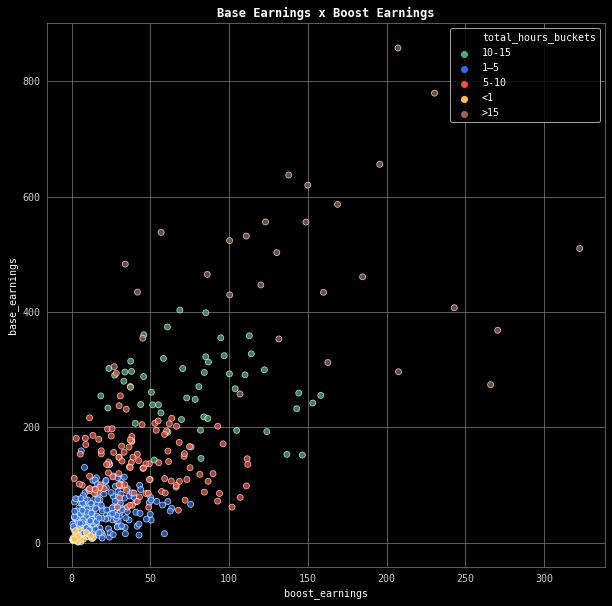

In [103]:
plt.figure(figsize=(10,10))
# plt.plot([x1,x2],[y1,y2])
sns.scatterplot(
    data=eff.sample(500, random_state=1).sort_values(by='total_hours_buckets')
    ,x='boost_earnings'
    ,y='base_earnings'
    ,hue='total_hours_buckets'
#     ,style='week'
    ,alpha=.75
)

plt.title('Base Earnings x Boost Earnings', weight='bold')
plt.show()

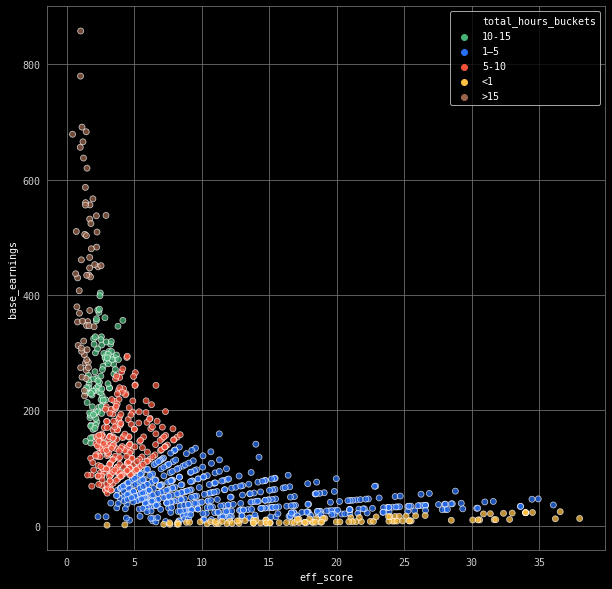

In [104]:
plt.figure(figsize=(10,10))
# plt.plot([x1,x2],[y1,y2])
sns.scatterplot(
    data=eff.sample(1000, random_state=1).sort_values(by='total_hours_buckets')
    ,x='eff_score'
    ,y='base_earnings'
    ,hue='total_hours_buckets'
    ,alpha=.75
)

plt.show()

In [26]:
# quickly round order totals into buckets
eff['order_buckets'] = np.where(
    eff.est_orders.round() > 10
    ,'>10'
    ,eff.est_orders.round()
)

/Users/thomasbriggs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [29]:
eff['boost_rate_rnd'] = pd.to_numeric(eff['boost_rate_rnd'])

eff['boost_rate_buckets'] = np.where(
    eff['boost_rate_rnd'] <= 1
    , eff['boost_rate_rnd']
    , np.where(
        (eff['boost_rate_rnd'] > 1) & (eff['boost_rate_rnd'] <= 1.5)
        , '1.5'
        , '2'
    )
)

eff['boost_rate_rnd'] = eff['boost_rate_rnd'].astype('category')
eff['boost_rate_buckets'].value_counts()

/Users/thomasbriggs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/thomasbriggs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/thomasbriggs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.25    27531
0.5     14835
0.0     10233
2        8101
0.75     6443
1.0      3262
1.5      2588
Name: boost_rate_buckets, dtype: int64

### Balancing the Boost Rates to see if there is correlation
It looks as if there is a more pronounced negative correlation between hourly earnings and boost score when you balance the data.

In [30]:
s = eff.sample(frac=1, random_state=1)

num_rows = 2588

bal = pd.DataFrame(columns=eff.columns)
# x1 = s.loc[s['boost_rate_buckets']==1][:2588]
for i in eff['boost_rate_buckets'].unique():
    x = s.loc[s['boost_rate_buckets']==i][:2588]
    bal = pd.concat([bal,x])

# bal = pd.concat([ontime, offtime])
bal= bal.sample(frac=1, random_state=40)

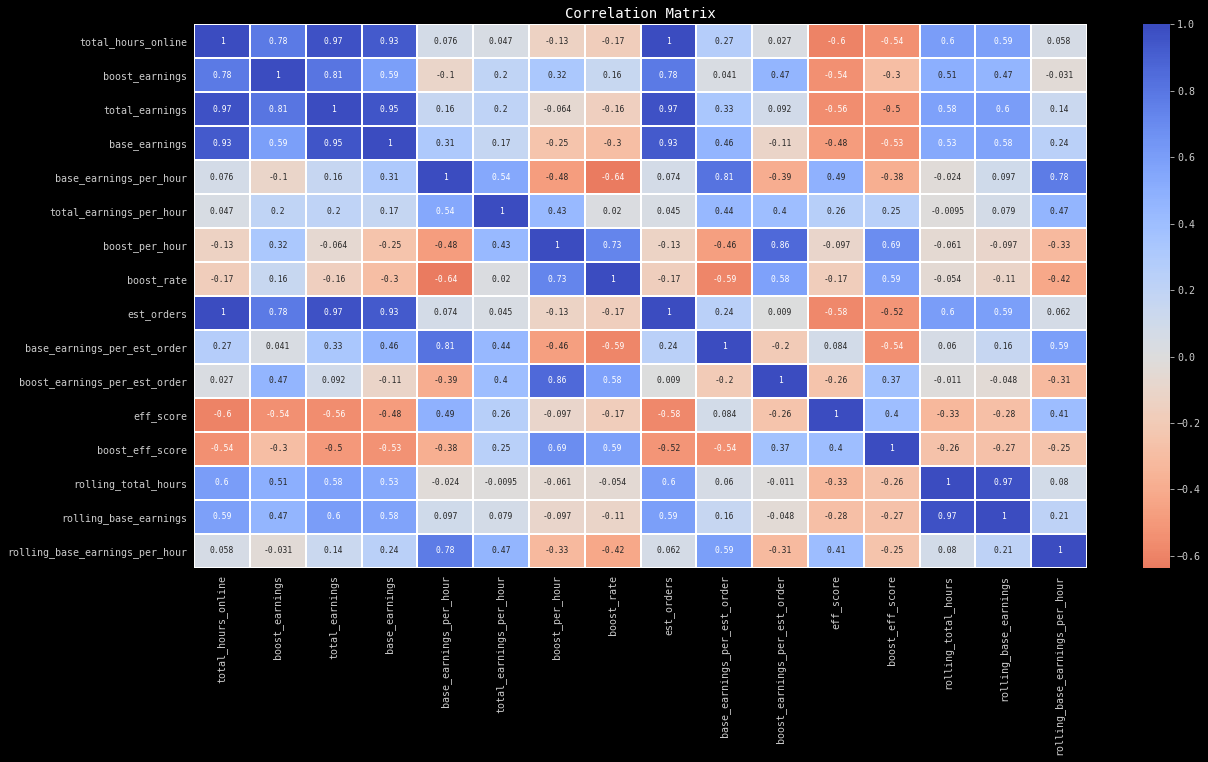

In [31]:
plt.figure(figsize=(20,10))
sample_corr = bal.corr()
sns.heatmap(sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':8}, center=0
           , linewidths=1
           )
plt.title('Correlation Matrix', fontsize=14)
plt.show()


In [32]:
bal['boost_rate_buckets'].value_counts()

0.5     2588
0.75    2588
1.5     2588
2       2588
0.25    2588
0.0     2588
1.0     2588
Name: boost_rate_buckets, dtype: int64

In [33]:
bal.week.unique()

array(['2019-10-28T00:00:00.000000000', '2019-11-25T00:00:00.000000000',
       '2019-11-04T00:00:00.000000000', '2019-11-18T00:00:00.000000000',
       '2019-11-11T00:00:00.000000000', '2019-12-02T00:00:00.000000000'],
      dtype='datetime64[ns]')

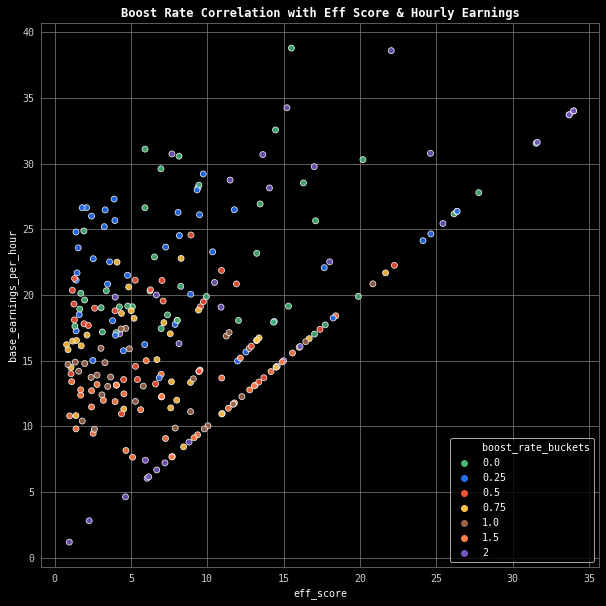

In [34]:
bal['boost_rate_buckets'] = bal['boost_rate_buckets'].astype('category')

plt.figure(figsize=(10,10))
# plt.plot([x1,x2],[y1,y2])
sns.scatterplot(
    data=bal.loc[(bal.est_orders > 1)|(bal.week_rn>1)].sample(250, random_state=1)
    ,x='eff_score'
    ,y='base_earnings_per_hour'
    ,hue='boost_rate_buckets'
#     ,size='est_orders'
    ,alpha=.9
)
plt.title('Boost Rate Correlation with Eff Score & Hourly Earnings', weight='bold')

plt.show()

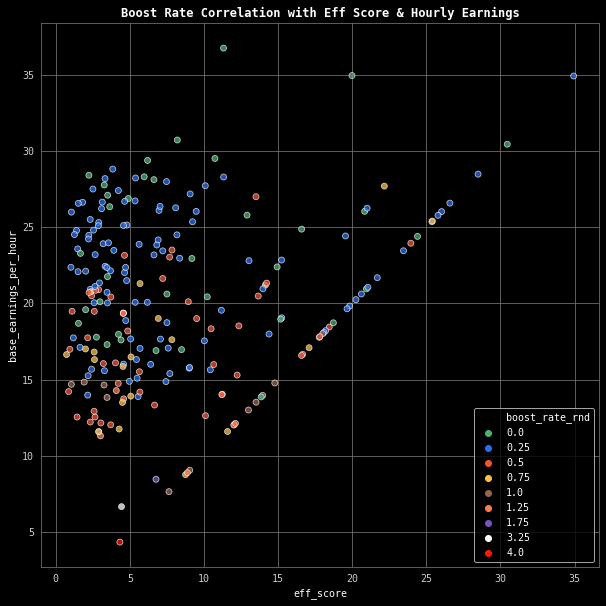

In [36]:
plt.figure(figsize=(10,10))
# plt.plot([x1,x2],[y1,y2])
sns.scatterplot(
    data=eff.sample(250, random_state=1)
    ,x='eff_score'
    ,y='base_earnings_per_hour'
    ,hue='boost_rate_rnd'
#     ,style='week'
    ,alpha=.75
)
plt.title('Boost Rate Correlation with Eff Score & Hourly Earnings', weight='bold')

plt.show()

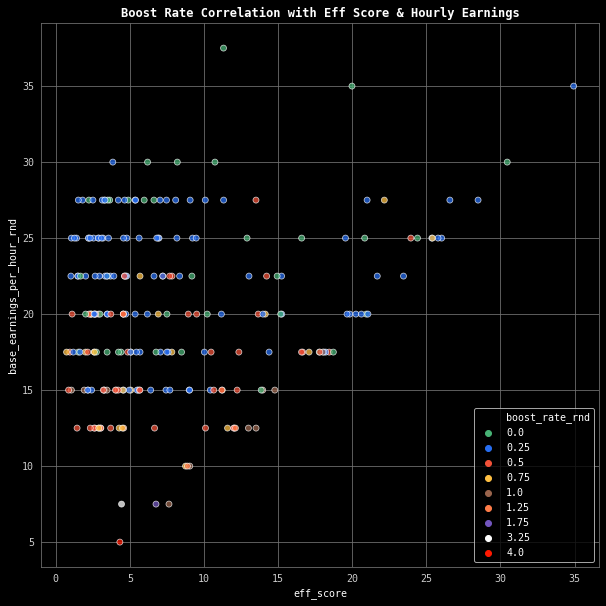

In [35]:
plt.figure(figsize=(10,10))
# plt.plot([x1,x2],[y1,y2])
sns.scatterplot(
    data=eff.sample(250, random_state=1)
    ,x='eff_score'
    ,y='base_earnings_per_hour_rnd'
    ,hue='boost_rate_rnd'
#     ,style='week'
    ,alpha=.75
)
plt.title('Boost Rate Correlation with Eff Score & Hourly Earnings', weight='bold')

plt.show()

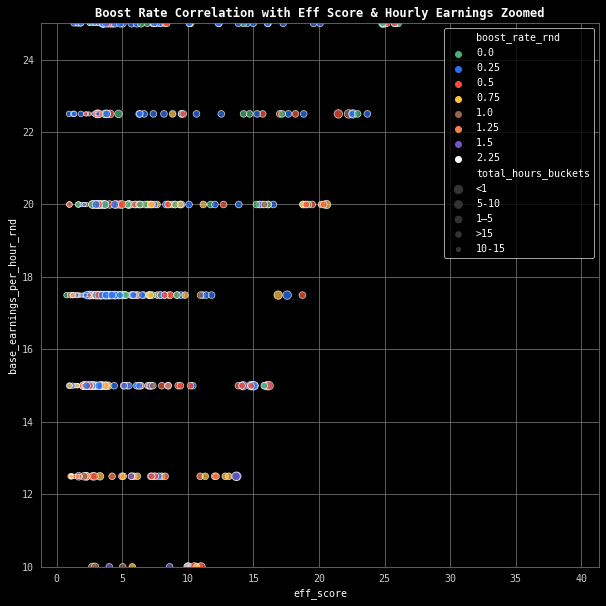

In [140]:
plt.figure(figsize=(10,10))
# plt.plot([x1,x2],[y1,y2])
sns.scatterplot(
    data=eff.loc[eff['base_earnings_per_hour']>10].sample(500, random_state=1)
    ,x='eff_score'
    ,y='base_earnings_per_hour_rnd'
    ,hue='boost_rate_rnd'
    ,size='total_hours_buckets'
#     ,style='week'
    ,alpha=.75
)
plt.title('Boost Rate Correlation with Eff Score & Hourly Earnings Zoomed', weight='bold')
plt.ylim([10,25])
plt.show()

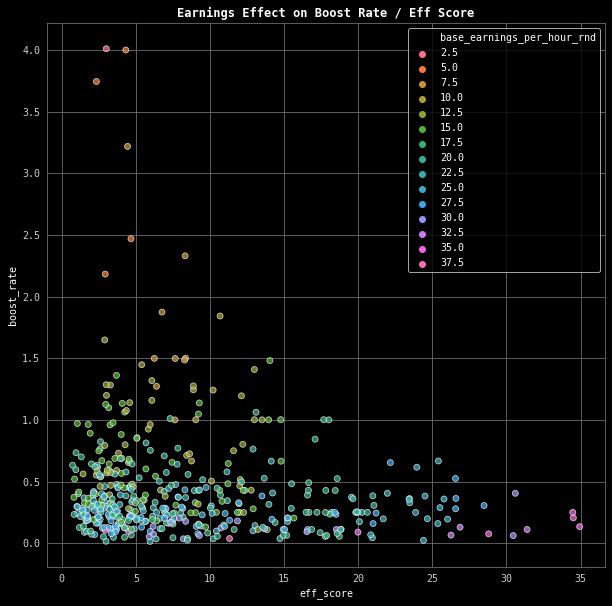

In [139]:
plt.figure(figsize=(10,10))
# plt.plot([x1,x2],[y1,y2])
sns.scatterplot(
    data=eff.sample(500, random_state=1)
    ,x='eff_score'
    ,y='boost_rate'
    ,hue='base_earnings_per_hour_rnd'
#     ,style='week'
    ,alpha=.75
)
plt.title('Earnings Effect on Boost Rate / Eff Score', weight='bold')
plt.show()

___

# Applying Boost Rate Variable
Using conditional logic, add the conditions for each bucket and load as a column

In [126]:
train['boost_rate_auto'] = np.where(
    train.boost_eligible_auto == 0
    ,None
    ,np.where(
        (train.boost_eligible_auto == 0)
        ,None
        ,np.where(
            (train.week_rn==1)&(train.est_orders==1)&(train.boost_eligible_auto == 1)
            ,0
            ,np.where(
                (train.base_earnings_per_hour<7.5)&(train.boost_eligible_auto == 1)
                ,1.5
                ,np.where(
                    (((train.base_earnings_per_hour>=7.5)&(train.base_earnings_per_hour<12.5))
                     &(train.eff_score<12.5)
                     &(train.boost_eligible_auto == 1)
                    )
                    ,1
                    ,np.where(
                        (((train.base_earnings_per_hour>=12.5)&(train.base_earnings_per_hour<15))
                         &(train.eff_score<15)
                         &(train.boost_eligible_auto == 1)
                        )
                        ,.75
                        ,np.where(
                            (((train.base_earnings_per_hour>=12.5)&(train.base_earnings_per_hour<20))
                             &(train.eff_score<20)
                             &(train.boost_eligible_auto == 1)
                            )
                            ,.5
                            ,np.where(
                                (((train.base_earnings_per_hour>=20)&(train.base_earnings_per_hour<23.75))
                                 &(train.eff_score<23.75)
                                 &(train.boost_eligible_auto == 1)
                                )
                                ,.25
                                ,np.where(
                                    (((train.base_earnings_per_hour>=23.75)&(train.base_earnings_per_hour<30))
                                     &(train.eff_score<30)
                                     &(train.boost_eligible_auto == 1)
                                    )
                                    ,.125
                                    ,np.where(
                                        ((train.base_earnings_per_hour>=30)
            #                              &(train.eff_score>=27.5)
                                         &(train.boost_eligible_auto == 1)
                                        )
                                        ,0
                                        ,None
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

/Users/thomasbriggs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [127]:
train.boost_rate_auto.count()

64003

In [128]:
train.boost_rate_auto.value_counts()

0.500    19549
0.125    14762
0.250    12083
0.750     6581
0.000     5541
1.000     4703
1.500      784
Name: boost_rate_auto, dtype: int64

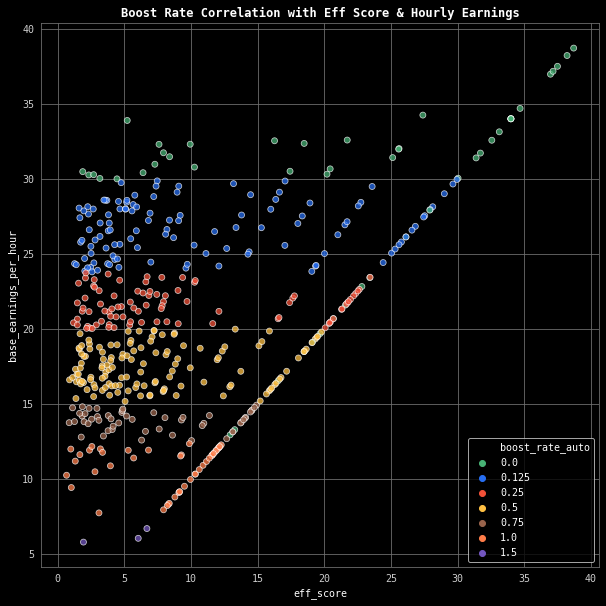

In [129]:
plt.figure(figsize=(10,10))
# plt.plot([x1,x2],[y1,y2])
sns.scatterplot(
    data=train.sample(1000, random_state=1)
    ,x='eff_score'
    ,y='base_earnings_per_hour'
    ,hue=train.boost_rate_auto.astype('category')
#     ,style='week'
    ,alpha=.75
)
plt.title('Boost Rate Correlation with Eff Score & Hourly Earnings', weight='bold')

plt.show()

___

# Evaluating Automation Variables
Will evaluate by checking against the manually added variables in the provided dataset

In [132]:
train['boost_rate_auto'] = pd.to_numeric(train['boost_rate_auto'])
train['auto_boost_earnings'] = train['base_earnings'] * train['boost_rate_auto']
train['auto_total_earnings'] = train['base_earnings'] + train['auto_boost_earnings']
train['auto_earnings_diff'] = train['auto_total_earnings'] - train['total_earnings']
train['auto_boost_diff'] = train['auto_boost_earnings'] - train['boost_earnings']

train.loc[train.boost_eligible_auto==1].head()

/Users/thomasbriggs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/thomasbriggs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/thomasbriggs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,week,partner_uuid,total_hours_online,boost_earnings,total_earnings,base_earnings,base_earnings_per_hour,total_earnings_per_hour,boost_per_hour,boost_rate,...,week_rn,rolling_base_earnings_per_hour,boost_rate_rnd,base_earnings_per_hour_rnd,boost_eligible_auto,boost_rate_auto,auto_boost_earnings,auto_total_earnings,auto_earnings_diff,auto_boost_diff
15087,2019-11-04,000614de-ad41-48cd-81b4-844c46dde6fa,12.000000,67.72,354.04,286.32,23.860000,29.503333,5.643333,0.236519,...,2,23.905135,0.25,25.0,1,0.125,35.79000,322.11000,-31.93000,-31.93000
15091,2019-11-04,000c1570-496c-41eb-a2c6-e3c836d2ce2e,3.000000,34.09,71.13,37.04,12.346667,23.710000,11.363333,0.920356,...,2,12.370000,1.00,12.5,1,1.000,37.04000,74.08000,2.95000,2.95000
15092,2019-11-04,000d4ad8-10cc-48b8-9b74-86cc4c52da6f,7.000000,29.47,138.82,109.35,15.621429,19.831429,4.210000,0.269502,...,2,15.267857,0.25,15.0,1,0.500,54.67500,164.02500,25.20500,25.20500
15095,2019-11-04,00127605-8f4e-43dc-8e50-34e4431c06dd,1.333333,3.52,41.63,38.11,28.582500,31.222500,2.640000,0.092364,...,2,30.411429,0.00,27.5,1,0.125,4.76375,42.87375,1.24375,1.24375
15096,2019-11-04,001a0434-2991-4fce-a443-89e6062cc3bb,11.000000,56.60,220.13,163.53,14.866364,20.011818,5.145455,0.346114,...,2,14.854412,0.25,15.0,1,0.750,122.64750,286.17750,66.04750,66.04750


In [133]:
evals = train.groupby('week').agg({
     'partner_uuid':'count'
    ,'total_hours_online':'sum'
    ,'est_orders':'sum'
    ,'boost_earnings':'sum'
    ,'total_earnings':'sum'
    ,'auto_boost_earnings':'sum'
    ,'auto_total_earnings':'sum'
#     ,'auto_earnings_diff':'sum'
    ,'auto_boost_diff':'mean'
    ,'boost_rate_auto':'count'
}).rename(columns={'boost_rate_auto':'num_boosters','partner_uuid':'num_partners','auto_boost_diff':'auto_boost_diff_mean'})

# Calculate some final metrics
evals['auto_boost_diff'] = evals['auto_boost_earnings'] - evals['boost_earnings']
evals['auto_earnings_diff'] = evals['auto_total_earnings'] - evals['total_earnings']
evals['courier_hours_perc_shift'] = evals.total_hours_online.pct_change()
evals['num_partners_perc_shift'] = evals.num_partners.pct_change()

evals

,num_partners,total_hours_online,est_orders,boost_earnings,total_earnings,auto_boost_earnings,auto_total_earnings,auto_boost_diff_mean,num_boosters,auto_boost_diff,auto_earnings_diff,courier_hours_perc_shift,num_partners_perc_shift
week,,,,,,,,,,,,,
2019-11-04,27863,87747.000000,74275.00,427351.94,2.764814e+06,442112.14000,2.168695e+06,0.077784,13392,14760.20000,-5.961195e+05,NaN,NaN
2019-11-11,28157,89021.333333,75247.50,477101.15,2.821325e+06,479786.94250,2.177413e+06,-1.127352,14040,2685.79250,-6.439120e+05,0.014523,0.010552
2019-11-18,33314,109605.666667,92029.00,519318.36,3.668270e+06,527389.02125,2.581494e+06,0.012966,14332,8070.66125,-1.086776e+06,0.231229,0.183152
2019-11-25,36814,114251.000000,96127.75,771282.73,3.819025e+06,725258.42000,2.396733e+06,-5.346982,14834,-46024.31000,-1.422293e+06,0.042382,0.105061
2019-12-02,14292,19551.000000,19853.75,96904.42,6.784205e+05,100585.17625,4.122293e+05,0.393872,7405,3680.75625,-2.661912e+05,-0.828877,-0.611778


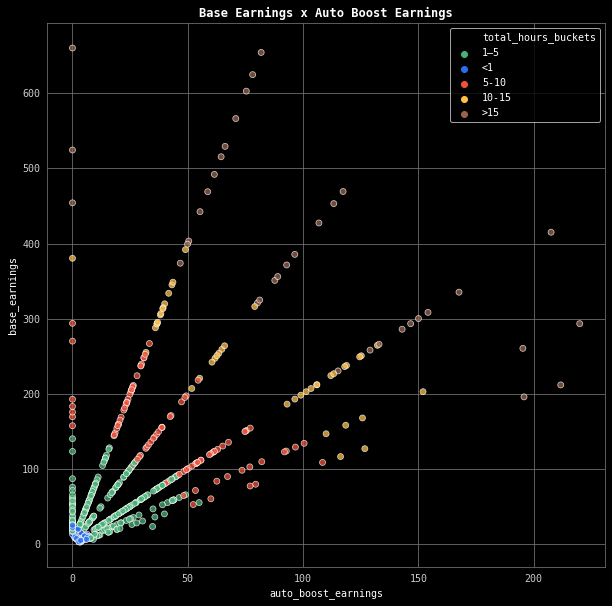

In [101]:
plt.figure(figsize=(10,10))
# plt.plot([x1,x2],[y1,y2])
sns.scatterplot(
    data=train.sample(1000, random_state=1)
    ,x='auto_boost_earnings'
    ,y='base_earnings'
    ,hue='total_hours_buckets'
#     ,style='week'
    ,alpha=.75
)

plt.title('Base Earnings x Auto Boost Earnings', weight='bold')
plt.show()

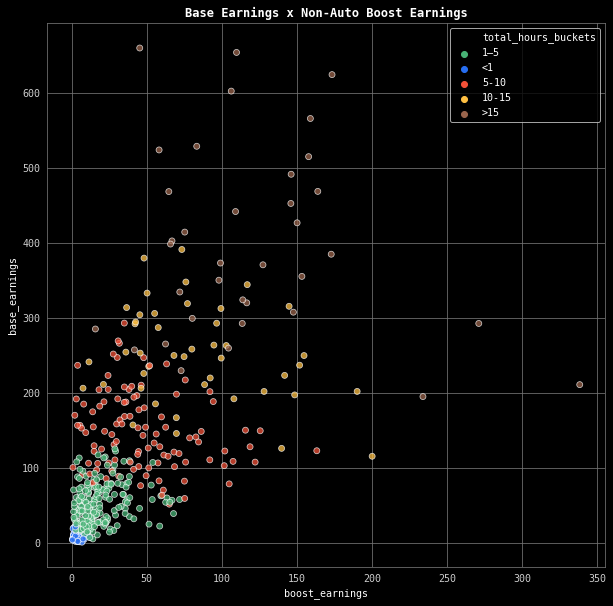

In [106]:
plt.figure(figsize=(10,10))
# plt.plot([x1,x2],[y1,y2])
sns.scatterplot(
    data=train.sample(1000, random_state=1)
    ,x='boost_earnings'
    ,y='base_earnings'
    ,hue='total_hours_buckets'
#     ,style='week'
    ,alpha=.75
)

plt.title('Base Earnings x Non-Auto Boost Earnings', weight='bold')
plt.show()

___